numpy

In [1]:
import numpy as np

In [18]:
cur_pos = np.array([3, 4, 5])

p_world = np.array([1, 2, 0]).reshape((3, 1))
goal_pos = np.hstack([p_world[0], p_world[1], 5])

goal_pos

array([1, 2, 5])

In [19]:
distance = np.linalg.norm(goal_pos - cur_pos)
distance

2.8284271247461903

In [22]:
MAXIMUM_INCREMENT = 0.5

if distance > MAXIMUM_INCREMENT:
    num_steps = int(round(distance / MAXIMUM_INCREMENT))
    steps = np.linspace(cur_pos, goal_pos, num_steps+1)[1:]
else:
    steps = goal_pos.reshape((1, 3))
    
steps

array([[2.66666667, 3.66666667, 5.        ],
       [2.33333333, 3.33333333, 5.        ],
       [2.        , 3.        , 5.        ],
       [1.66666667, 2.66666667, 5.        ],
       [1.33333333, 2.33333333, 5.        ],
       [1.        , 2.        , 5.        ]])

In [24]:
goal_pos is None

False

sweep path

In [51]:
bounds = np.array([[-2, -2],    # min xy, max xy
                   [ 5,  5]])   # make this an attribute loaded in via launch

# construct sweep path
x_min, y_min = bounds[0]
x_max, y_max = bounds[1]

MAXIMUM_INCREMENT = 0.5

x_steps = int(np.floor((x_max - x_min) / MAXIMUM_INCREMENT)) + 1
y_steps = int(np.floor((y_max - y_min) / MAXIMUM_INCREMENT)) + 1

x_vals = np.linspace(x_min, x_min + MAXIMUM_INCREMENT*(x_steps -1), x_steps)
y_vals = np.linspace(y_min, y_min + MAXIMUM_INCREMENT*(y_steps - 1), y_steps)

coords = []

for idx, y in enumerate(y_vals):
    if idx % 2 == 0:
        x_row = x_vals
    else:
        x_row = x_vals[::-1]
        
    y_row = np.full_like(x_row, y)
    row_coords = np.column_stack((x_row, y_row))
    coords.append(row_coords)
    
coords = np.vstack(coords)
reverse_coords = coords[-2::-1]
full_coords = np.vstack((coords, reverse_coords))

GOAL_HEIGHT = 2.
sweep_path = np.hstack([full_coords, np.ones((full_coords.shape[0], 1)) * GOAL_HEIGHT])

# find starting index
distances = np.linalg.norm(sweep_path - cur_pos, axis=1)

step_counter = np.argmin(distances)

steps = sweep_path

setpoint = steps[step_counter]

total points: 161
x by y: 9 by 9


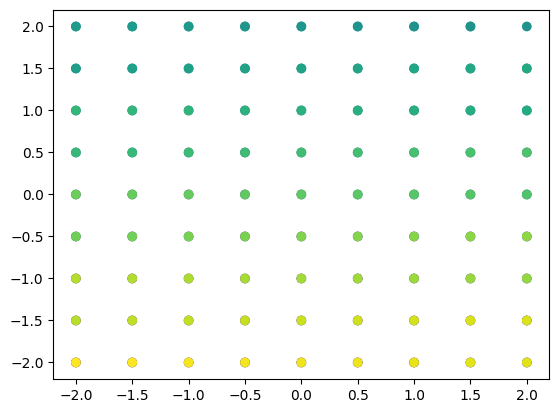

In [29]:
import matplotlib.pyplot as plt 

print(f"total points: {full_coords.shape[0]}")
print(f"x by y: {x_steps} by {y_steps}")
plt.scatter(full_coords[:, 0], full_coords[:, 1], c=np.arange(full_coords.shape[0]))

bounds

In [55]:
import yaml 

with open("../config/bounds.yaml", 'r') as f:
    bounds = yaml.safe_load(f)
    
min_x = bounds['min_x']
max_x = bounds['max_x']
min_y = bounds['min_y']
max_y = bounds['max_y']

In [56]:
min_x

-2

evaluate

In [34]:
200 * 2.5

500.0

In [44]:
import numpy as np 
from scipy.spatial.transform import Rotation as R 

# K = np.array([[390.39080648,   0.        , 420.        ],
#             [  0.        , 519.24695544, 240.        ],
#             [  0.        ,   0.        ,   1.        ]])
K = np.array([[500, 0, 424],
              [0, 500, 240],
              [0, 0, 1]])


C_dc = np.array([[ 0, -1,  0],
                 [-1,  0,  0],
                 [ 0,  0, -1]])

obs = np.array([[221, 200]]).T
x_zebra_c = np.array([[450, 405, 2]]).T
p_camera = np.array([[-1, -0.16, 2]]).T 
p_world = np.array([[-0.87, 0.35, 0]]).T 

x_drone = np.array([[-1, -0.7, 2]]).T 
r_drone = [0.0334, -0.003, 0., -0.999]
x_zebra = np.array([[-0.55, -0.84, 0]]).T 

In [55]:
K

array([[500,   0, 424],
       [  0, 500, 240],
       [  0,   0,   1]])

In [ ]:
# np.save("../config/sim_cameraK.npy", K)

In [56]:
os.getcwd()

'/home/yifei/capstone/Capstone/drone_ws/src/visual_servoing/visual_servoing'

In [36]:
rotation = R.from_quat(r_drone)
C_wd = rotation.as_matrix()

T_wd = np.vstack([np.hstack([C_wd, x_drone]), [0, 0, 0, 1]])

T_dc = np.vstack([np.hstack([C_dc, np.zeros((3, 1))]), [0, 0, 0, 1]])

In [45]:
depth = 2.5
obs2 = np.array([[130, 340]]).T

t = np.array([[0.03, 0.01, 2.4]]).T
T_wd = np.vstack([np.hstack([np.eye(3), t]), [0, 0, 0, 1]])

x_zebra2 = np.vstack([obs * depth, depth])
p_camera2 = np.linalg.inv(K) @ x_zebra2 
p_world2 = T_wd @ T_dc @ np.vstack([p_camera2, 1])
p_world2[:3]

array([[ 0.23 ],
       [ 1.025],
       [-0.1  ]])

In [48]:
t = np.array([[0. ,0., 2.4]]).T
zebra = np.array([[-1, 2, 0]]).T
np.linalg.inv(T_wd) @ np.vstack([zebra, 1])

array([[-1.03],
       [ 1.99],
       [-2.4 ],
       [ 1.  ]])

In [51]:
a = np.linalg.inv(T_dc) @ np.linalg.inv(T_wd) @ np.vstack([zebra, 1])
a

array([[-1.99],
       [ 1.03],
       [ 2.4 ],
       [ 1.  ]])

In [54]:
b = K @ a[:3]
b / b[2]

array([[  9.41666667],
       [454.58333333],
       [  1.        ]])

In [50]:
p_camera2

array([[-1.015],
       [-0.2  ],
       [ 2.5  ]])

In [28]:
obs

array([[221],
       [200]])

In [27]:
x_zebra2

array([[442.],
       [400.],
       [  2.]])

In [29]:
p_camera2

array([[-1.99],
       [-0.4 ],
       [ 2.  ]])

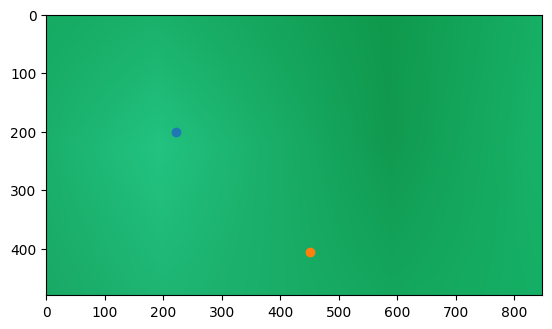

In [16]:
import matplotlib.pyplot as plt

img = plt.imread("../../../sim_capture.png")
plt.imshow(img)

plt.scatter(obs[0], obs[1])
plt.scatter(x_zebra_c[0], x_zebra_c[1])

In [20]:
img.shape

(480, 848, 3)

In [12]:
import os
os.getcwd()

'/home/yifei/capstone/Capstone/drone_ws/src/visual_servoing/visual_servoing'

In [8]:
T_wd

array([[ 9.99981984e-01, -2.00575391e-04,  5.99924598e-03,
        -1.00000000e+00],
       [-2.00575391e-04,  9.97766927e-01,  6.67916053e-02,
        -7.00000000e-01],
       [-5.99924598e-03, -6.67916053e-02,  9.97748912e-01,
         2.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [6]:
rotation.as_euler('xyz')

array([-0.06684257,  0.00599928, -0.00020058])